# 【財務諸表を元にした指標】
株式銘柄の分析では、財務諸表の生値だけを使うのではなく、いくつかの項目を組み合わせて指標を作ることがあります（財務指標）。例えばPERやROEなどがこれに当たります。よく使われる財務指標は、四季報やYahoo FinanceのStatisticsなどを参照すると分かります。

https://finance.yahoo.com/quote/7203.T/key-statistics?p=7203.T


In [2]:
import pickle
import datetime
import warnings

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.dates import date2num, DayLocator, DateFormatter
from mpl_finance import candlestick2_ohlc, volume_overlay

from IPython.display import Image

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import ExtraTreesRegressor
from tqdm.auto import tqdm

%matplotlib inline
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100
pd.options.display.width = 120
warnings.simplefilter('ignore')

In [3]:
def pickle_dump(obj, path):
    with open(path, mode='wb') as f:
        pickle.dump(obj,f)

def pickle_load(path):
    with open(path, mode='rb') as f:
        data = pickle.load(f)
        return data

In [4]:
# チュートリアルのtrain_X, val_X, test_X, train_y, val_y, test_y　私はpickleで保存しています
# ""の中身はご自身の環境に合わせて定義してください
train_X = pickle_load("...")
val_X = pickle_load("...")
test_X = pickle_load("...")
train_y = pickle_load("...")
val_y = pickle_load("...")
test_y = pickle_load("...")

In [5]:
# データセットの読み込み
# ""の中身はご自身の環境に合わせて定義してください
dataset_dir="..."
inputs = {
    "stock_list": f"{dataset_dir}/stock_list.csv",
    "stock_price": f"{dataset_dir}/stock_price.csv",
    "stock_fin": f"{dataset_dir}/stock_fin.csv",
    "stock_labels": f"{dataset_dir}/stock_labels.csv",
}

dfs = {}
for k, v in inputs.items():
    dfs[k] = pd.read_csv(v)

本コンペで使うことができる財務諸表の項目はメジャーなものに限られていますが、これだけあればいくつかのよく使われる財務指標を作ることができます。主だったものは以下のようになります。

- market_cap（時価総額）
- PER（株価収益率）
- PBR（株価純資産倍率）
- ROE（自己資本利益率）
- profit_margin(売上高純利益率、単に純利益率)
- equity_ratio（自己資本比率）

In [6]:
tmp_df = train_X["label_high_20"].copy()

# stock_price情報のマージ
tmp_df = tmp_df.reset_index()
tmp_df = tmp_df.set_index(["datetime", "code"])

tmp_stock_price = dfs["stock_price"].copy()
tmp_stock_price["datetime"] = pd.to_datetime(tmp_stock_price["EndOfDayQuote Date"])
tmp_stock_price = tmp_stock_price[["datetime", "Local Code", "EndOfDayQuote Close"]]
tmp_stock_price.columns = ["datetime", "code", "close"]
tmp_stock_price = tmp_stock_price.set_index(["datetime", "code"])
tmp_df = pd.concat([tmp_df, tmp_stock_price[tmp_stock_price.index.isin(tmp_df.index)]], axis=1)

In [7]:
# stock_list情報のマージ
tmp_df = tmp_df.reset_index()
tmp_df = tmp_df.set_index("code")

tmp_stock_list = dfs["stock_list"].copy()
tmp_stock_list = tmp_stock_list[["Local Code", "17 Sector(Code)", "33 Sector(Code)", "Size Code (New Index Series)", "IssuedShareEquityQuote IssuedShare"]]
tmp_stock_list.columns = ["code", "sector17", "sector33", "size_group", "share"]
tmp_stock_list = tmp_stock_list.set_index("code")
tmp_df = tmp_df.join(tmp_stock_list)

In [8]:
# 財務指標の作成
tmp_df["market_cap"] = tmp_df["close"]*tmp_df["share"]
tmp_df["per"] = tmp_df["close"]/(tmp_df["Result_FinancialStatement NetIncome"]*1000000/tmp_df["share"])
tmp_df["per"][tmp_df["Result_FinancialStatement CashFlowsFromOperatingActivities"] == 0] = np.nan
tmp_df["pbr"] = tmp_df["close"]/(tmp_df["Result_FinancialStatement NetAssets"]*1000000/tmp_df["share"])
tmp_df["roe"] = tmp_df["pbr"]/tmp_df["per"]
tmp_df["profit_margin"] = tmp_df["Result_FinancialStatement NetIncome"]/tmp_df["Result_FinancialStatement NetSales"]
tmp_df["profit_margin"][tmp_df["Result_FinancialStatement CashFlowsFromOperatingActivities"] == 0] = np.nan
tmp_df["equity_ratio"] = tmp_df["Result_FinancialStatement NetAssets"]/tmp_df["Result_FinancialStatement TotalAssets"]
tmp_df

,datetime,return_1month,return_2month,return_3month,volatility_1month,volatility_2month,volatility_3month,MA_gap_1month,MA_gap_2month,MA_gap_3month,Result_FinancialStatement FiscalYear,Result_FinancialStatement NetSales,Result_FinancialStatement OperatingIncome,Result_FinancialStatement OrdinaryIncome,Result_FinancialStatement NetIncome,Result_FinancialStatement TotalAssets,Result_FinancialStatement NetAssets,Result_FinancialStatement CashFlowsFromOperatingActivities,Result_FinancialStatement CashFlowsFromFinancingActivities,Result_FinancialStatement CashFlowsFromInvestingActivities,Forecast_FinancialStatement FiscalYear,Forecast_FinancialStatement NetSales,Forecast_FinancialStatement OperatingIncome,Forecast_FinancialStatement OrdinaryIncome,Forecast_FinancialStatement NetIncome,Result_Dividend FiscalYear,Result_Dividend QuarterlyDividendPerShare,Result_Dividend AnnualDividendPerShare,Forecast_Dividend FiscalYear,Forecast_Dividend QuarterlyDividendPerShare,Forecast_Dividend AnnualDividendPerShare,close,sector17,sector33,size_group,share,market_cap,per,pbr,roe,profit_margin,equity_ratio
code,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1301,2016-02-05,-0.022140,0.000000,0.000000,0.016141,0.000000,0.000000,1.000189,0.000000,0.000000,2016.0,178890.0,2467.0,2688.0,1133.0,114363.0,23417.0,0.0,0.0,0.0,2016.0,229000.0,2600.0,3000.0,2200.0,0.0,0.00,0.0,2016.0,5.00,5.0,2650.0,1,50,7,10928283.0,2.895995e+10,NaN,1.236706,NaN,NaN,0.204760
1301,2016-05-09,0.015564,-0.036900,-0.015094,0.010985,0.012129,0.012798,1.002112,0.987701,0.990951,2016.0,226626.0,2433.0,2814.0,1799.0,94608.0,23065.0,2689.0,2482.0,-5114.0,2017.0,117000.0,1400.0,1300.0,800.0,2016.0,5.00,5.0,2017.0,50.00,50.0,2610.0,1,50,7,10928283.0,2.852282e+10,15.854819,1.236628,0.077997,0.007938,0.243795
1301,2016-08-05,-0.011407,-0.029851,-0.011407,0.009727,0.011334,0.009773,0.989157,0.991704,0.986343,2017.0,52206.0,467.0,380.0,551.0,101632.0,22995.0,0.0,0.0,0.0,2017.0,117000.0,1400.0,1300.0,800.0,2016.0,5.00,5.0,2017.0,50.00,50.0,2600.0,1,50,7,10928283.0,2.841354e+10,NaN,1.235640,NaN,NaN,0.226257
1301,2016-11-04,-0.024240,0.025475,0.037308,0.007637,0.008217,0.007867,0.980620,0.986900,0.999926,2017.0,109570.0,1171.0,1004.0,1186.0,106554.0,23600.0,0.0,0.0,0.0,2017.0,244000.0,3500.0,3300.0,2100.0,2016.0,5.00,5.0,2017.0,50.00,50.0,2697.0,1,50,7,10928283.0,2.947358e+10,NaN,1.248880,NaN,NaN,0.221484
1301,2017-02-10,0.008450,0.018175,0.044918,0.004767,0.005084,0.005005,1.007839,1.006462,1.013570,2017.0,179975.0,2872.0,2827.0,2449.0,117168.0,25779.0,0.0,0.0,0.0,2017.0,244000.0,3500.0,3300.0,2100.0,2016.0,5.00,5.0,2017.0,50.00,50.0,2745.0,1,50,7,10928283.0,2.999814e+10,NaN,1.163666,NaN,NaN,0.220017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9997,2017-01-31,0.071923,0.210938,0.105563,0.022805,0.019928,0.021212,1.010694,1.081458,1.117466,2017.0,109639.0,7711.0,9423.0,6321.0,179491.0,86044.0,0.0,0.0,0.0,2017.0,140000.0,11000.0,11000.0,7000.0,2017.0,6.25,0.0,2017.0,6.25,12.5,775.0,14,6100,6,97244472.0,7.536447e+10,NaN,0.875883,NaN,NaN,0.479378
9997,2017-05-11,0.233371,0.299287,0.324455,0.019115,0.019036,0.017618,1.093617,1.184399,1.218195,2017.0,146083.0,10882.0,12188.0,5802.0,179024.0,87773.0,8214.0,2995.0,-9945.0,2018.0,73000.0,4200.0,4500.0,2900.0,2017.0,6.25,12.5,2018.0,6.25,0.0,1094.0,14,6100,6,97244472.0,1.063855e+11,18.335997,1.212052,0.066102,0.039717,0.490286
9997,2017-07-31,-0.054396,-0.029817,0.238049,0.010996,0.016590,0.024089,0.975929,0.972507,0.997485,2018.0,41153.0,2870.0,3544.0,3105.0,182619.0,89332.0,0.0,0.0,0.0,2018.0,73000.0,4200.0,4500.0,2900.0,2017.0,6.25,12.5,2018.0,6.25,0.0,1269.0,14,6100,6,97244472.0,1.234032e+11,NaN,1.381400,NaN,NaN,0.489171


さて、ここで純利益率に注目してみます。純利益率は各業種によって大きく分布が異なります。利益率の高い業種もあれば低い業種もあるということです。一例として、自動車・輸送機セクターと銀行セクターの利益率の分布を比較してみます。

## 図1.純利益率 - 自動車・輸送機セクターと銀行セクターの比較

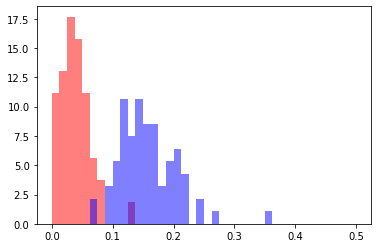

In [9]:
tmp_df2 = tmp_df[(tmp_df["datetime"]>=datetime.datetime(2016,4,1)) & (tmp_df["datetime"]<datetime.datetime(2016,7,1))].copy()

fig = plt.figure()
ax = fig.add_subplot(1,1,1)

ax.hist(tmp_df2["profit_margin"][tmp_df2["sector17"]==6], density=True, bins=40, color='red', alpha=0.5, range=(0, 0.5))
ax.hist(tmp_df2["profit_margin"][tmp_df2["sector17"]==15], density=True, bins=40, color='blue',alpha=0.5, range=(0, 0.5))
fig.show()

これを見ると、銀行のほうが全体的に高い純利益率であることが分かります。ここで重要なことは、これらの純利益率を単純に比較して良いか？ということです。

株式の分析では業種の違いによる純利益率のギャップは周知の事実であり、業種を隔ててそれらを比較するようなことはしません。UFJ銀行とトヨタの純利益率を比較しても仕方がありません。やるのであれば、トヨタと日産など同じ業種内で純利益率を比較してどちらが有望か判断するのです。

こう考えるとこのような財務指標は絶対値の大小ではなく、業種の中での相対値の大小が重要となります。従って、財務指標の前処理では業種毎に正規化することが一般的です。